In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
import sklearn
from sklearn.base import TransformerMixin

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 9, 4

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from codes.plotting_funcs import plot_eda_features
from codes.plotting_funcs import plot_heatmap
from codes.plotting_funcs import plot_corr_target
from codes.plotting_funcs import plot_countplots

In [6]:
from tqdm.notebook import tqdm
from IPython.display import display
pd.options.display.max_columns = 100

In [7]:
SEED = 10

In [8]:
df_train = pd.read_csv('data_cleaned/df.csv')
df_test = pd.read_csv('data_cleaned/df_test.csv')
with open('features_types_cleaned.json') as features_types_file:
    features_types = json.load(features_types_file)
    
floats = set(features_types['float'])
ints = set(features_types['int'])
binary = set(features_types['binary'])
cats = set(features_types['categorical'])
indicators = set(features_types['nan_indicators'])
    
df_train.shape

(69809, 120)

In [9]:
dfs = {'train': df_train, 'test': df_test}

In [10]:
def drop_features(dfs, features, floats=floats, ints=ints, binary=binary, cats=cats):
    print('num_cols then: {}'.format(dfs['train'].shape[1]))
    
    try:
        dfs['train'].drop(columns=features, inplace=True)
        dfs['test'].drop(columns=features, inplace=True)
    except:
        print('Already dropped')
        pass
    
    fset = set(features)
    floats -= fset
    ints -= fset
    binary -= fset
    cats -= fset
    dfs['train'].shape[1]
    
    print('num_cols now: {}'.format(dfs['train'].shape[1]))
    

# def decode_cats(dfs, lcats):
#     oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(df_train[lcats])
#     for key in dfs:
#         dfs[key][lcats] = oe.transform(dfs[key][lcats]).astype(int)

# EDA

Перед построением качественной модели нужно проводить EDA. Не очень хорошо для получения важной информации и инсайтов строить много графиков и пытаться анализировать все, что попадается под руку. Наиболее выигрышный на мой взгляд способ -- введение гипотез о влиянии тех или иных признаков на таргет.

Здесь гипотеза появляется необязательно в статистическом смысле: в основном под гипотезой я подразумеваю некое предположение, которое необязательно проверять статистическими методами.

Я буду анализировать целочисленные, бинарные и категориальный признаки. Непрерывных признаков очень много, и они сложноинтерпретируемые, проще всего здесь провести отбор.

Будем считать, что значение `churn` равно 1, если отток и 0 иначе.

In [11]:
df_train.churn.value_counts()

0    35230
1    34579
Name: churn, dtype: int64

Обучающая выборка может считаться сбалансированной.

# Анализ целочисленных признаков

In [12]:
print(ints)

{'numbcars', 'months', 'lor', 'phones', 'uniqsubs', 'models', 'eqpdays', 'hnd_price', 'actvsubs', 'adults'}


Для начала отрисуем взаимные корреляции (целочисленных) признаков -- важно понять, какие парные связи следует анализировать.

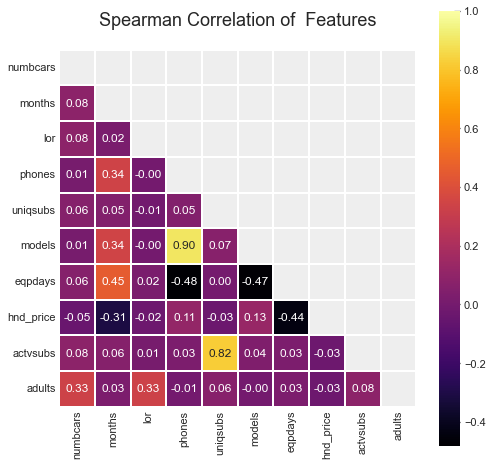

In [13]:
plot_heatmap(df_train[ints], colormap='inferno', figsize=(8, 8))

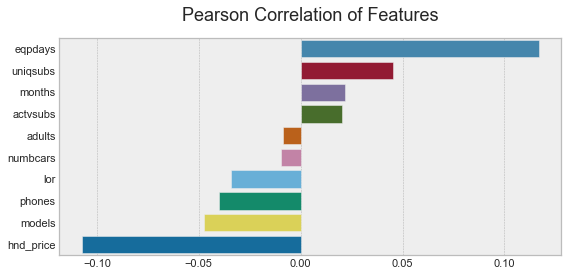

In [14]:
plot_corr_target(df_train, ints, (5, 2))

В целом эти признаки слабо коррелируют с целевой переменной, но все же следует их исследовать.

Признак `hnd_price` имеет наибольший коэффициент корреляции. Выведем его распределение.

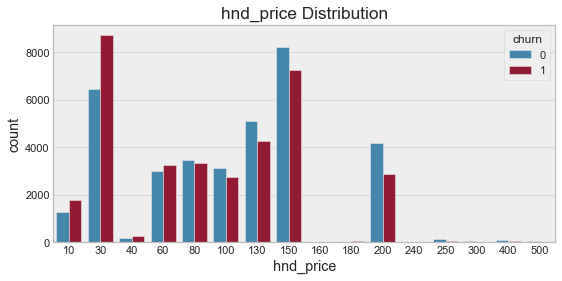

In [15]:
_ = sns.countplot(data=df_train, x='hnd_price', hue='churn')
plt.title('hnd_price Distribution')
plt.show()

Похоже, признак является действительно важным.

## Гипотеза-1 : большое число подписок (подписчиков)/времени в сети/звонков способствует удержанию пользователя

Речь идет о признаках `uniqsubs`, `actvsubs`, `months`, `eqpdays`, `totcalls`. Предполагается, что чем выше значение этих признаков у объекта, тем меньше вероятность его оттока.

In [16]:
df_group = df_train.groupby('churn')

In [17]:
df_group[['uniqsubs', 'actvsubs', 'months', 'eqpdays']].mean()

,uniqsubs,actvsubs,months,eqpdays
churn,,,,
0,1.487936,1.331053,18.728726,366.920409
1,1.565979,1.356083,19.136094,424.714885


In [18]:
np.expm1(df_group['log1p_totcalls'].mean())

churn
0    1756.160323
1    1813.221704
Name: log1p_totcalls, dtype: float64

По анализу средних мы видим, что для признаков `uniqsubs`, `actvsubs`, `log1p_totcalls` и `months` нет существенной разницы.

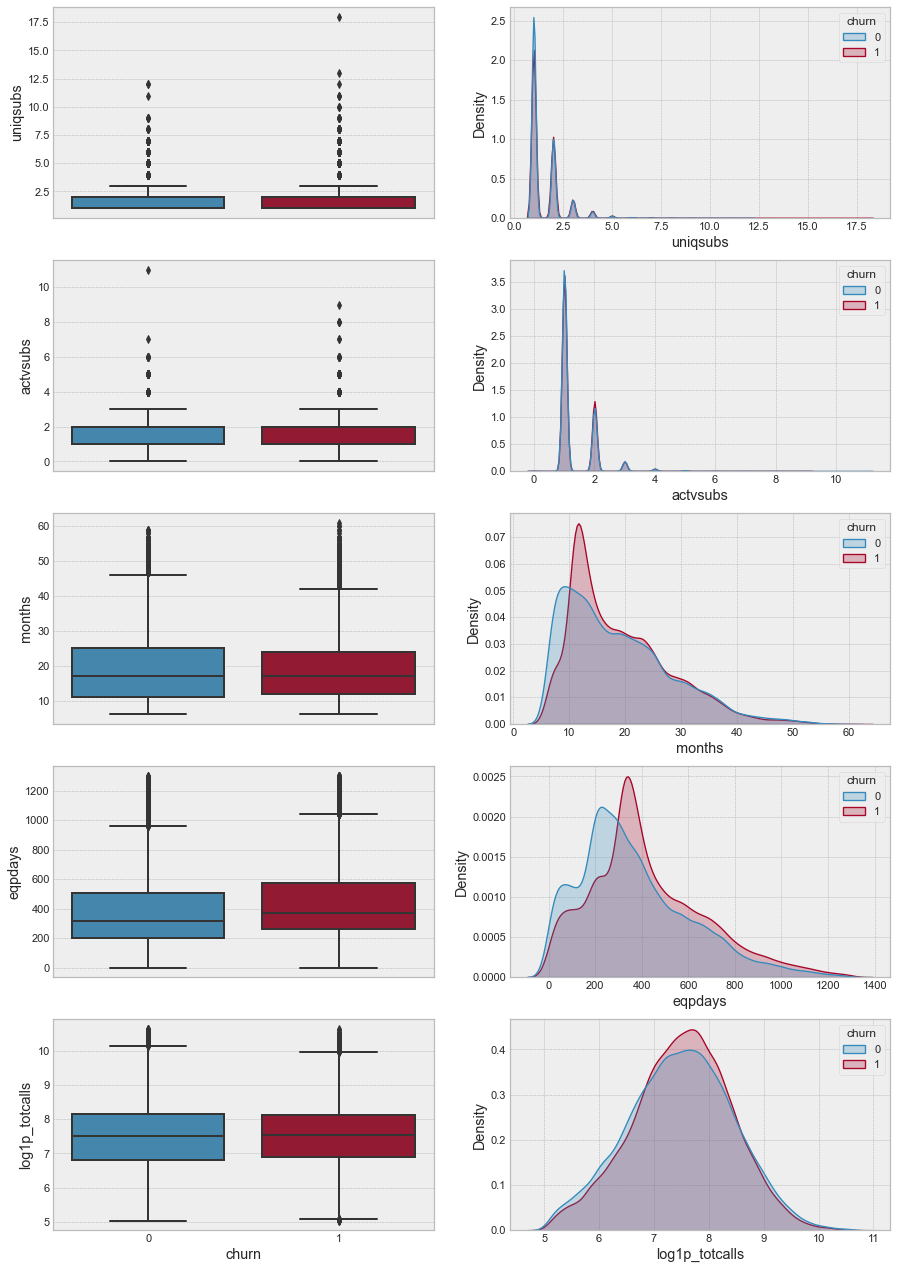

In [19]:
hypo_1_feats = ['uniqsubs', 'actvsubs', 'months', 'eqpdays', 'log1p_totcalls']
plot_eda_features(df_train, hypo_1_feats)

**Инсайт-1:**
* признаки `uniqsubs`, `actvsubs` не влияют на целевую переменную, так как их распределения идентичны;
* нет существенного различия и в случае, если признак `months` имеет значения свыше 20. В основном пользователь может уйти, если провел в сети от 10 до 12 месяцев. Пользователи с меньшим значением скорее всего не уйдут;
* Для положительного класса распределение `eqpdays` смещено вправо с большим значением моды, что говорит о том, что большие значения этого признака способствуют оттока с большей вероятностью;
* Для обоих классов распределения `totcalls` идентичны -- мода и среднее близки, однако между значениями логарифма 7 и 8.5 вероятность оттока выше.

По боксплотам размах квантилей отличается у `eqpdays` и незначительно у `months`, у остальных же они одинаковы (вплоть до совпадения медиан). Ясно, что большинство этих этих признаков не принесут пользы, поэтому можно выкинуть все, кроме `eqpdays` и `months`.

In [20]:
drop_features(dfs, ['uniqsubs', 'actvsubs', 'log1p_totcalls'])

num_cols then: 120
num_cols now: 117


Введем дополнительный признак: индикатор того, что прошло меньше 20 месяцев.

In [21]:
df_train['months_lt_20'] = (df_train['months'] < 20).astype(int)
df_test['months_lt_20'] = (df_test['months'] < 20).astype(int)
binary |= set(['months_lt_20'])

## Гипотеза-2: признаки `adults`, `lor` и `numbcars` незначимы

Имеют место корреляции лишь между `adults` и `lor`, `adults` и `numbcars`. Стоит посмотреть на их распределения -- вероятно, эти признаки не несут в себе никакой пользы и влияния на целевую переменную.

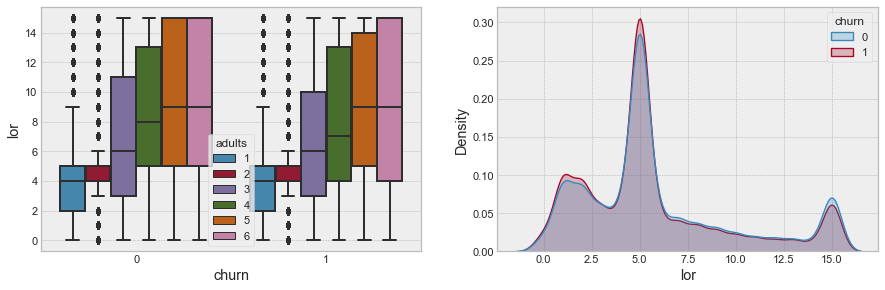

In [22]:
plot_eda_features(df_train, ['lor'], hue='adults')

Для `lor` гипотеза подтвеждена -- разница в распределениях незначительна. Единственное что -- имеется незначительная разница в разбросе для значения `adults` 5. В целом, признак не несет в себе ценности, поэтому его можно удалить.

Посмотрим на `numbcars`. Скорее всего, чем больше взрослых, тем больше и машин.

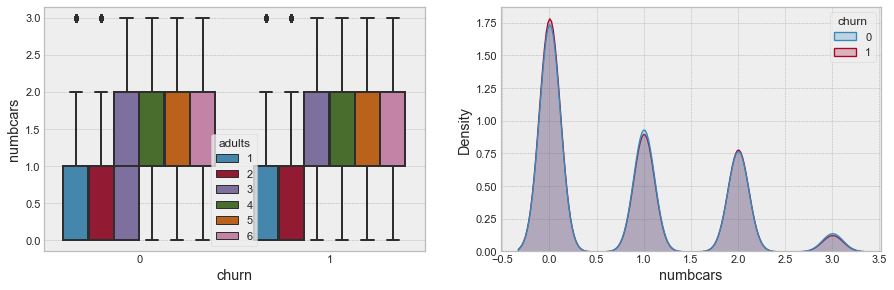

In [23]:
plot_eda_features(df_train, ['numbcars'], hue='adults')

Здесь мы видим, что в целом все одинаково, но существует меньше пар (взрослых 3, машин 0) для положительного класса.

In [24]:
df_train[df_train.adults == 3].groupby(['churn', 'numbcars'])['numbcars'].count()

churn  numbcars
0      0           1243
       1           1800
       2           1632
       3            261
1      0           1143
       1           1674
       2           1618
       3            226
Name: numbcars, dtype: int64

Разница невелика, поэтому особой значимости нет. Все эти признаки можно убрать.

**Инсайт-2:** признаки `lor`, `adults` и `numbcars` являются лишними, так как не было найдено какого-то либо влияния на целевую переменную или различий в распределениях по классам. Иными словами, эти признаки не помогут предсказать отток пользователя. Косвенно это подтверждается корреляцией.

In [25]:
drop_features(dfs, ['lor', 'adults', 'numbcars'])

num_cols then: 118
num_cols now: 115


# Анализ категориальных признаков

На этом этапе мой подход с гипотезами себя исчерпал: свое дело сыграли отсутствие информации о признаков, их количество, и, забегая вперед, их распределения по классам практически всегда очень похожи. Поэтому в дальнейшем анализ будет проводиться без четкого регламента и структуры.

In [26]:
df_train[cats].nunique()

new_cell             3
income              10
dwllsize            16
prizm_social_one     6
crclscod            52
HHstatin             7
hnd_webcap           4
dualband             4
area                20
marital              6
ethnic              18
dtype: int64

Чтобы иметь общее представление о категориальных данных, следует вывести их распределения.

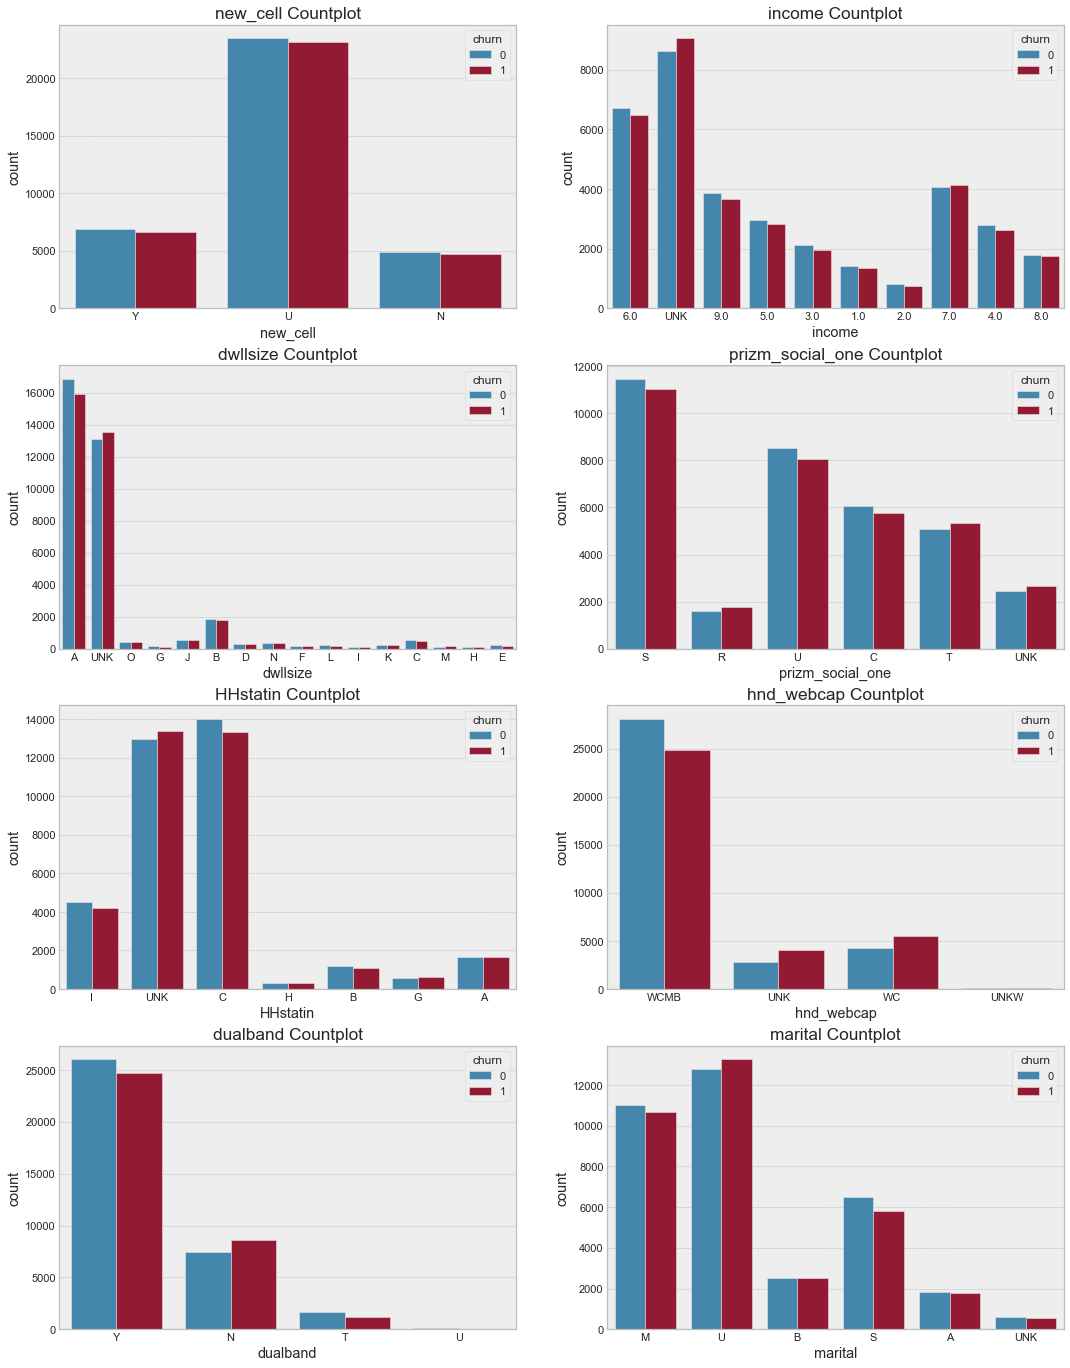

In [27]:
plot_countplots(df_train, cats - set(['crclscod', 'ethnic', 'area']))

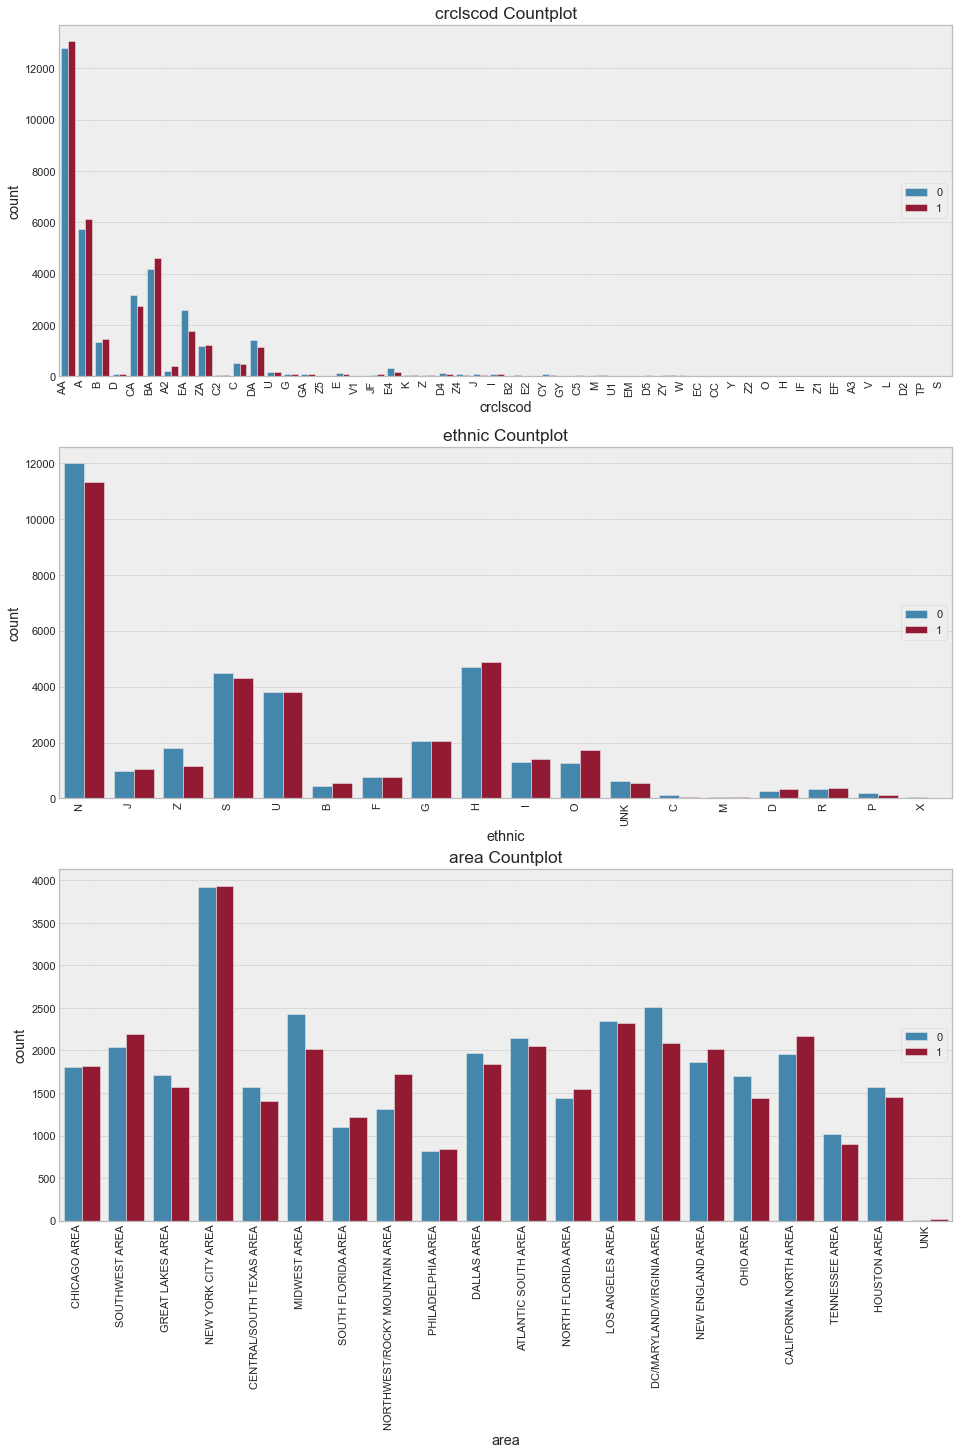

In [28]:
fig, axes = plt.subplots(nrows=3, squeeze=True, figsize=(16, 22))

for i, cat in enumerate(['crclscod', 'ethnic', 'area']):
    ax = axes[i]
    sns.countplot(data=df_train, x=cat, hue='churn', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    ax.set_title('{} Countplot'.format(cat))
    ax.legend(loc='right')
plt.show()

Распределения по большей части похожи, но имеются и различия.

Заметим, что у некоторых признаков очень много категорий, которые имеют малую долю в выборке. Объединим их и закодируем категорией `OTH` те категории, доля которых в данных менее 2%.

In [29]:
class UnionTransformer(TransformerMixin):
    def __init__(self, restricted='UNK', percent_less=2.0, cols_to_encode=None, encode_by='OTH'):
        '''
            restricted: values not to encode
            percent_less: union values with frequence less
            cols_to_encode: columns to encode
                            if None, find automatically
            encode_by: value to union by
        '''
        if type(restricted) == list:
            self.restricted = set(restricted)
        else:
            self.restricted = set([restricted])
        self.percent_less = percent_less
        self.cols_to_encode = cols_to_encode
        self.encode_by = encode_by
        
    def fit(self, data: pd.DataFrame):
        self.len = data.shape[0]
        itercols = data.columns if self.cols_to_encode is None else self.cols_to_encode
        self.fixed_cols = {}
        
        for col in itercols:
            values_freqs = data[col].value_counts() / self.len * 100
            cats = values_freqs[values_freqs <= self.percent_less].index
            if len(cats) > 1:
                self.fixed_cols[col] = list(set(cats) - self.restricted)         
        return self
        
    def transform(self, data: pd.DataFrame):
        for (col, vallist) in self.fixed_cols.items():
            data.loc[data[col].isin(vallist), col] = self.encode_by
        
        return data[self.cols_to_encode] if self.cols_to_encode is not None else data

In [30]:
to_encode = ['crclscod', 'ethnic', 'dwllsize']
ut = UnionTransformer(cols_to_encode=to_encode).fit(df_train)
for key in dfs:
    dfs[key][to_encode] = ut.transform(dfs[key])

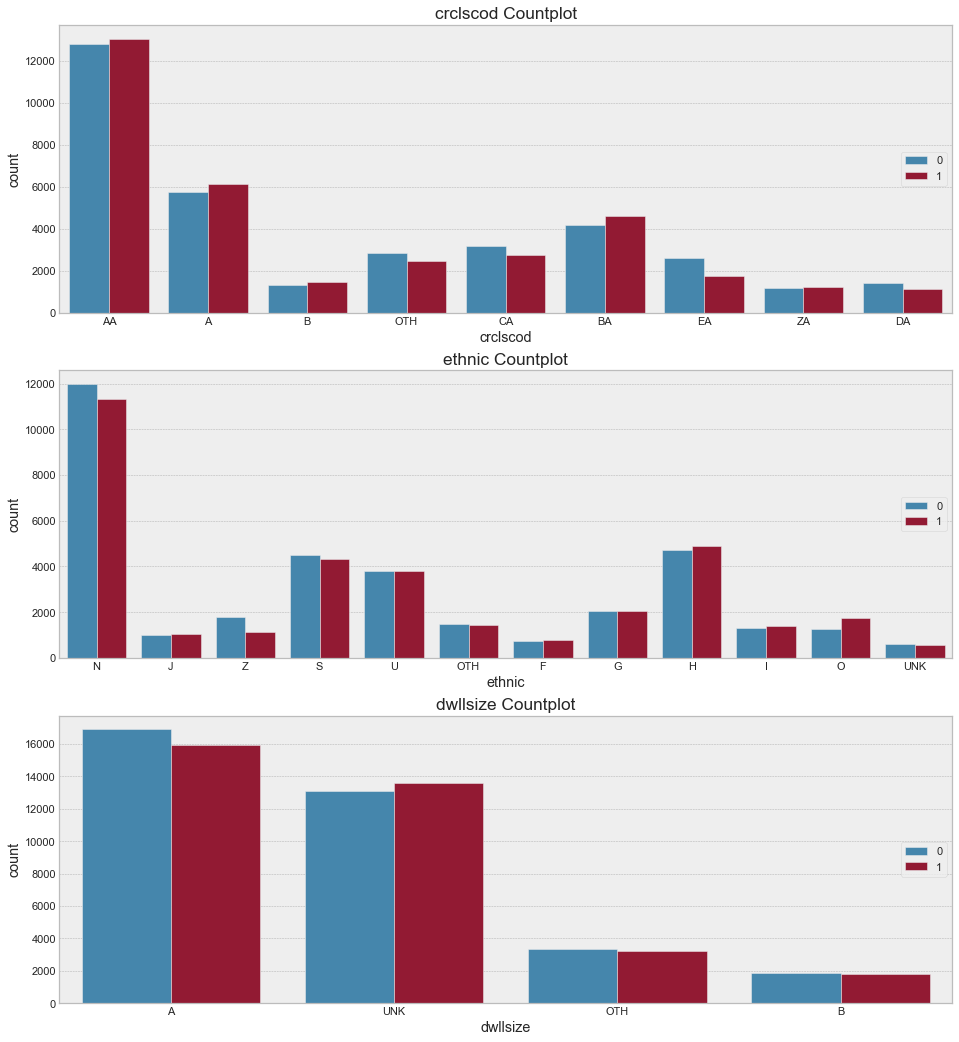

In [31]:
fig, axes = plt.subplots(nrows=3, squeeze=True, figsize=(16, 18))

for i, cat in enumerate(to_encode):
    ax = axes[i]
    sns.countplot(data=df_train, x=cat, hue='churn', ax=ax)
    ax.set_title('{} Countplot'.format(cat))
    ax.legend(loc='right')
plt.show()

## Анализ признака дохода

Вероятно, доход явлется важным фактором для предсказания оттока. Что, если пользователь использовал бесплатный пробный период услуги, а затем отказался от нее ввиду низкого дохода?

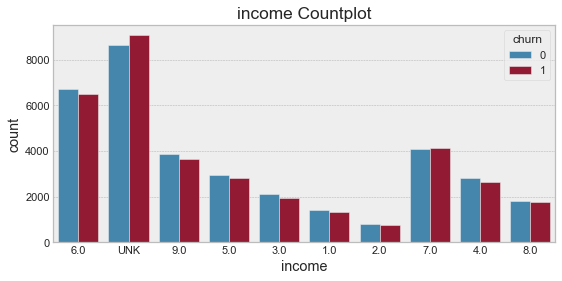

In [32]:
_ = sns.countplot(data=df_train, hue='churn', x='income')
plt.title('income Countplot')
plt.show()

Видно, что сам по себе показатель (уровень) дохода не влияет на отток, к тому же много значений пропущено. Больше всего людей со средним доходом (6-7). Следует рассматривать этот признак вместе с другими.

Например, посмотрим, как связан доход с семейным положением.

In [33]:
# plt.figure(figsize=(15, 5))
# _ = sns.countplot(data=df_train, x='marital', hue='income')
# plt.legend(loc='right')
# plt.title('incom - marital Countplot')
# plt.show()

Для многих объектов с категорией `U` доход неизвествен. Возможно, `U` означает `Unknown`, поэтому следует объединить эти значения.

In [34]:
for key in dfs:
    dfs[key].loc[dfs[key]['marital'] == 'UNK', 'marital'] = 'U'

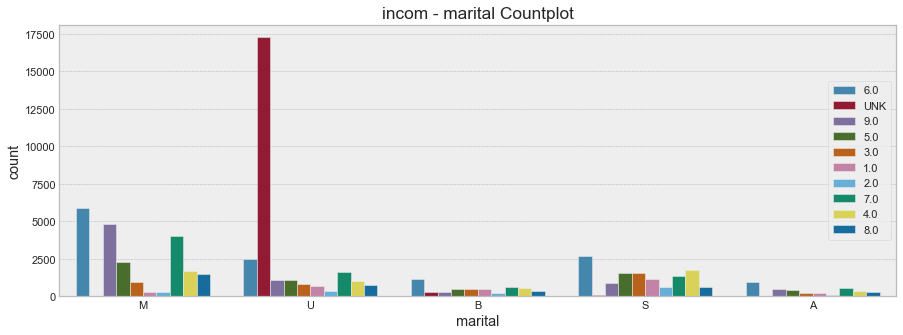

In [35]:
plt.figure(figsize=(15, 5))
_ = sns.countplot(data=df_train, x='marital', hue='income')
plt.legend(loc='right')
plt.title('incom - marital Countplot')
plt.show()

 В целом видно, что для разных категорий семейного положения распределения дохода сильно разнится. 
 
 **Инсайт-3:** так, например, в категории `M` мало объектов с низким уровнем дохода (1-4), и довольно много со средним и большим (6-7, 9). Для категории `B` распределение дохода близко к равномерному, мода среднего дохода (6). Категория `U` -- наиболее многочисленна, однако большая часть значений дохода -- пропущена, но картина распределения дохода идентична предыдущему графику (выше).
 
Посмотрим на признак `marital`: может быть, он хорошо коррелирует с таргетом.

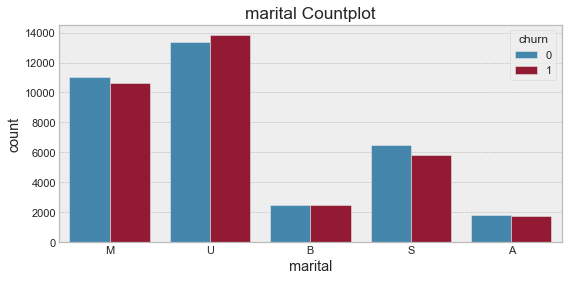

In [36]:
_ = sns.countplot(data=df_train, hue='churn', x='marital')
plt.title('marital Countplot')
plt.show()

К сожалению, это не так.

Рассмотрим этнический признак. Уровень дохода (как и образования, например) может меняться от группе к группе в зависимости от национальности и регионального размещения группы.

In [37]:
for key in dfs:
    dfs[key].loc[dfs[key]['ethnic'] == 'UNK', 'ethnic'] = 'U'

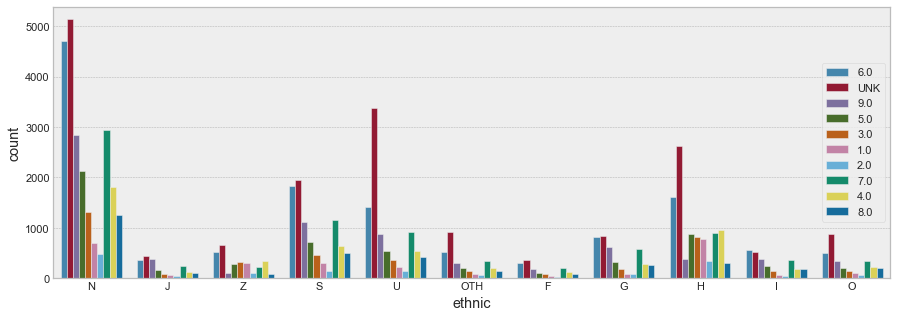

In [38]:
plt.figure(figsize=(15, 5))
_ = sns.countplot(data=df_train, x='ethnic', hue='income')
plt.legend(loc='right')
plt.show()

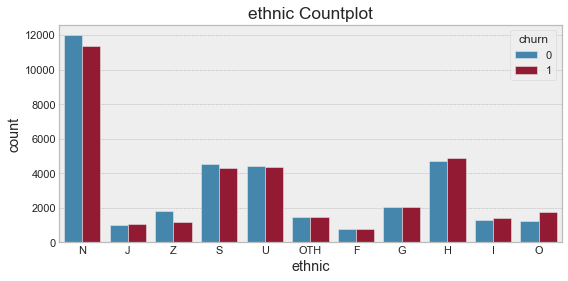

In [39]:
_ = sns.countplot(data=df_train, hue='churn', x='ethnic')
plt.title('ethnic Countplot')
plt.show()

Видим аналогичную картину: распределение дохода по большему счету разное для каждой категории (но есть категории с пропорциональным распределением), но этнический признак не влияет на таргет. **Инсайт-4** заключается в том, что не выделяются этнические категории с преимущественно низкими или высокими доходами, кроме категории `J` (jews?) -- здесь почти одинаковый процент людей с уровнями 6 и 9. В остальных мода -- 6 (не считая неизвестных).

По той же логике исследуем признак `area`.

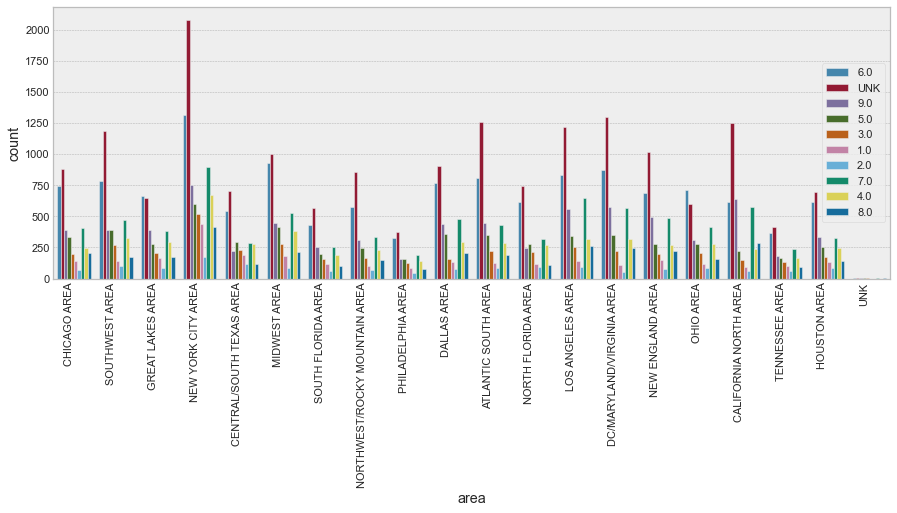

In [40]:
plt.figure(figsize=(15, 5))
p = sns.countplot(data=df_train, x='area', hue='income')
p.set_xticklabels(p.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.legend(loc='right')
plt.show()

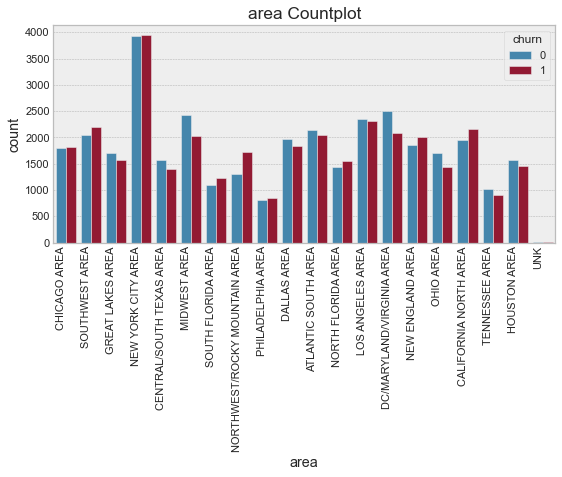

In [41]:
p = sns.countplot(data=df_train, hue='churn', x='area')
p.set_xticklabels(p.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title('area Countplot')
plt.show()

С точки зрения дохода -- не зависит от региона. Однако сам по себе региональный признак больше других коррелирует с таргетом. Например, вероятность оттока больше для `Northwest/Rocky Mountain area`, напротив -- для `Midwest area`.

Для других признаков можно провести аналогичный анализ и поделить категории по доходу, однако полученные инсайты вряд ли окажутся полезными. Единственное полезное, что можно выделить -- это предположить, например, для признака `hnd_webcap`, что категория `UNK` на самом деле `WC` -- они имеют идентичные распределения. Но этот момент вообще говоря спорный.

In [42]:
for key in dfs:
    dfs[key].loc[dfs[key]['hnd_webcap'] == 'UNKW', 'hnd_webcap'] = 'UNK'

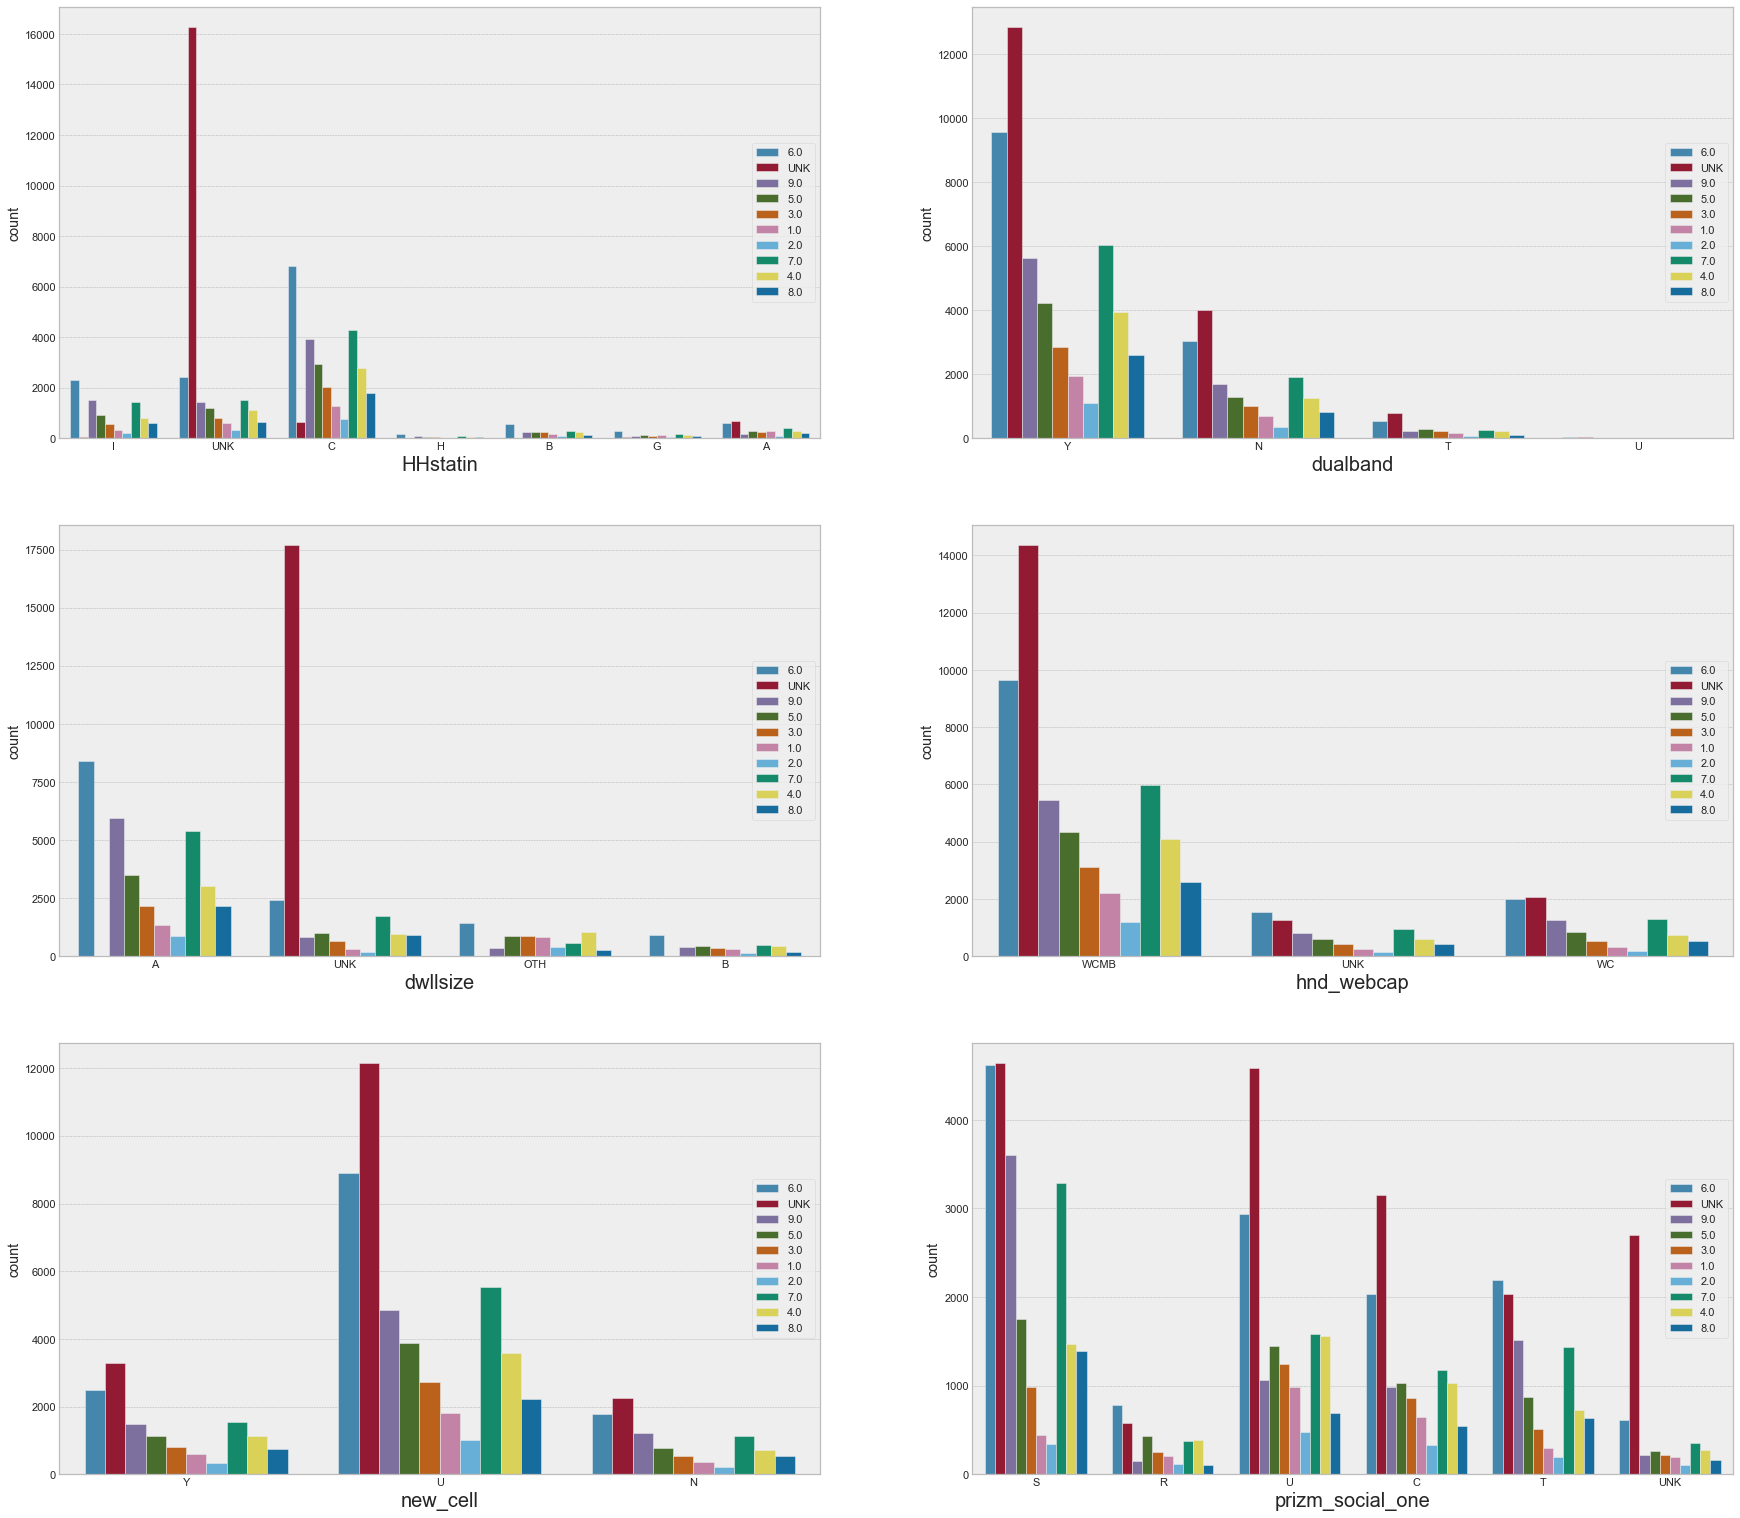

In [43]:
last = ['HHstatin', 'dualband', 'dwllsize',
        'hnd_webcap', 'new_cell', 'prizm_social_one']

fig, axes = plt.subplots(ncols=2, nrows=3, squeeze=False, figsize=(30, 27))

for i, feature in enumerate(last):
    ax = axes[i // 2][i % 2]
    sns.countplot(data=df_train, x=feature, hue='income', ax=ax)
    ax.set_xlabel(feature, fontsize=20)
    ax.legend(loc='right')
plt.show()

## Беглый взгляд на бинарные признаки

Здесь тоже не видно особого влияния на целевую переменную. Если проводить многомерный анализ с другими признакими, то мы вряд ли получим ценную информацию.

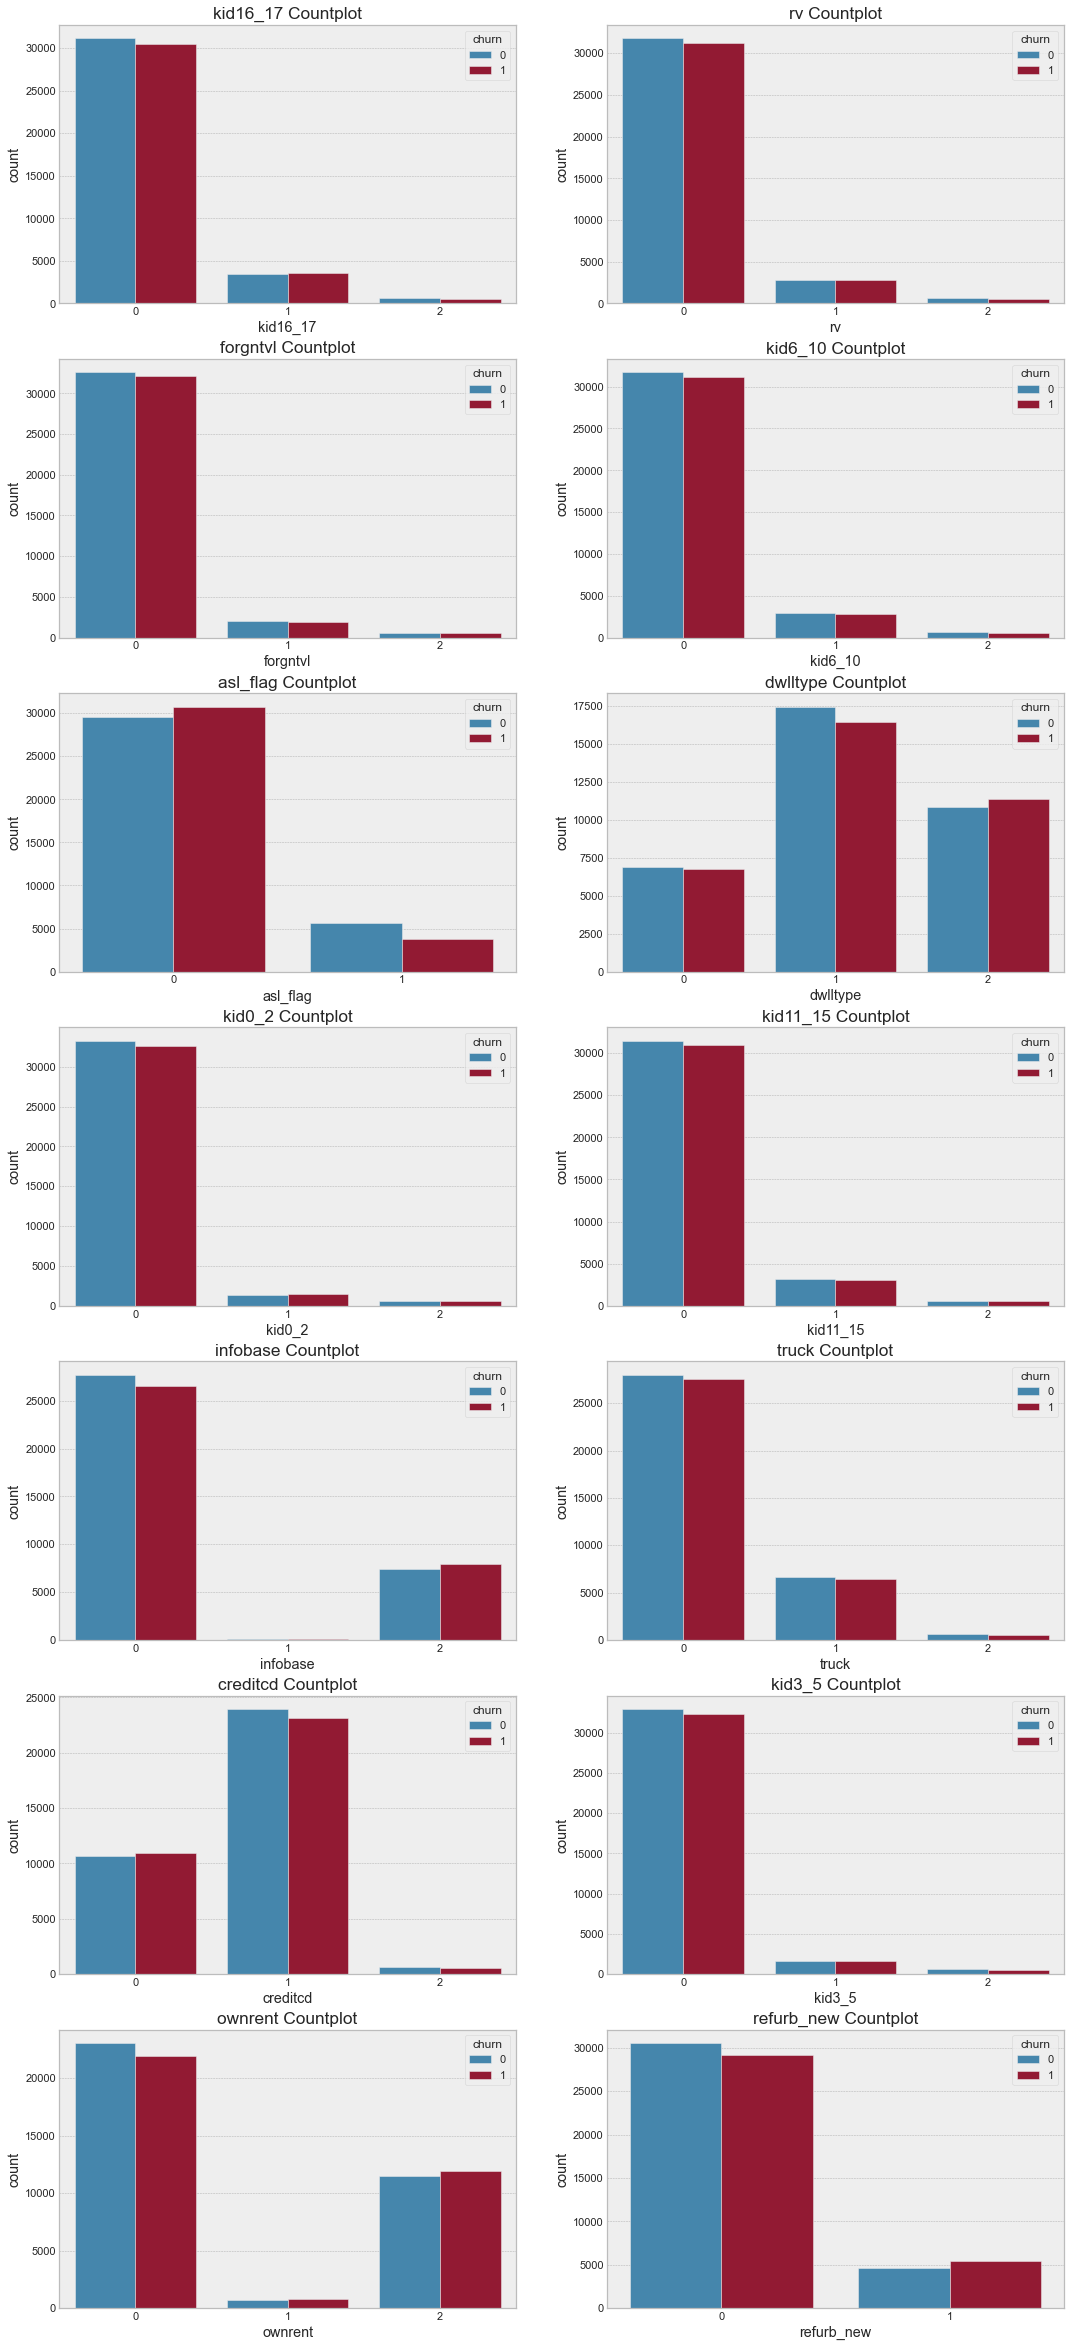

In [44]:
plot_countplots(df_train, binary - set(['months_lt_20']))

`dwlltype` каким-то образом попал в множество бинарных признаков, хотя на самом деле он категориален.

In [45]:
binary -= set(['dwlltype'])
cats |= set(['dwlltype'])

**Итак, я провел смысловую часть EDA. Были сделаны некоторые инсайты по категориальным данных, однако не было выделено явной корреляции какого-либо признака с таргетом, что плохо. Однако были выделены потенциально полезные целочисленные признаки. Следующий шаг -- моделирование.**

In [46]:
features_dict = {
    'float': list(floats),
    'int': list(ints),
    'binary': list(binary),
    'categorical': list(cats),
    'nan_indicators': list(indicators),
    'target': 'churn',
}

In [47]:
assert df_train.shape[1] == len(floats) + len(ints) + len(binary) + len(cats) + len(indicators) + 1
df_train.shape[1]

115

In [48]:
try:
    os.mkdir('data_final')
except:
    pass

df_train.to_csv('data_final/df.csv', index=False)
df_test.to_csv('data_final/df_test.csv', index=False)

jsonStr = json.dumps(features_dict)
file = open('features_types_final.json', 'w')
file.write(jsonStr)
file.close()